<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/econml/cm_causality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ライブラリのインストール
- econml（マイクロソフト）

In [1]:
!pip install econml

     |████████████████████████████████| 317kB 5.1MB/s 
     |████████████████████████████████| 110.5MB 34kB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
     |████████████████████████████████| 6.7MB 52.5MB/s 
     |████████████████████████████████| 512kB 51.7MB/s 
     |████████████████████████████████| 3.8MB 58.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=933923c96dbdf76f5c65d31296db11431cdf9a5c5576a88fb792a9ecc0ad744a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: sparse 0.10.0 has requirement numba>=0.49, but you'll have numba 0.48.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.2.

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
cd /gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML

/gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/econML


In [4]:
ls

cm_causality.ipynb  econML_readDocumet.ipynb  model/


# アプリのCMを見たことで、アプリの利用時間がどのくらい増加したか分析（CATEの算出）

## データの前処理

### 分析対象のデータ読み込み

In [0]:
import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
DATA_DIR = "../datasets"
CSV_FIEL = "game_cm_abtest.csv"
data_path = DATA_DIR + "/" + CSV_FIEL

In [7]:
read_data = pd.read_csv(data_path)
read_data.head(3)

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0


#### 統計量の確認

In [8]:
# 欠損数及び統計量の確認
read_data.describe()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.414400,0.074000,0.091200,0.588700,0.111500,0.208600,40.841900,0.640300,0.647000,0.566200,0.054200,0.075900,0.012300,0.117700,0.099900,0.039900,0.033900,357.829700,3.55234,0.148000,0.144800,0.620400,0.069900,0.016900,0.42300,0.013200,0.127800,0.173300,0.052200,0.140300,0.328800,0.164400,8096.497203,2846.783400,9.433300
std,0.492643,0.261784,0.287908,0.492094,0.314766,0.406328,10.465434,0.479936,0.477927,0.495623,0.226423,0.264851,0.110227,0.322269,0.299882,0.195734,0.180981,267.408383,3.37777,0.355118,0.351917,0.485312,0.254991,0.128903,0.49406,0.114136,0.333884,0.378525,0.222441,0.347315,0.469801,0.370657,7709.497437,17973.608991,54.475214
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.875270,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2502.245967,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,349.500000,2.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5944.444520,0.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,44.500000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,549.500000,4.00000,0.000000,0.000000,1.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11154.786148,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,800.000000,20.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,49036.055042,364814.000000,765.000000


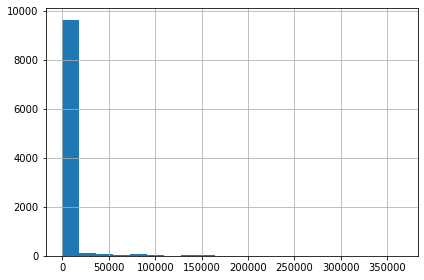

In [9]:
# アウトカムの分布を確認
read_data["gamesecond"].hist(bins=20)
plt.tight_layout()
plt.show()

### 不要なカラムの削除

In [10]:
UNNECESSARY_COLUMNS = ["gamedummy", "gamecount"]
analysis_data = read_data.drop(columns=UNNECESSARY_COLUMNS)
analysis_data.head(1)

,cm_dummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond
0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.4276,0


### 主要な列名を定数で管理

In [0]:
# 介入変数
TREATMENT_COLUMN = "cm_dummy"
# アウトカム
OUTCOME_COLUMN = "gamesecond"
# 交絡因子
COVARIATE_COLUMNS = [c for c in analysis_data.columns if c != TREATMENT_COLUMN and c != OUTCOME_COLUMN]

### 訓練データとテストデータに分割

In [0]:
from sklearn.model_selection import train_test_split

In [13]:
train_data, test_data = train_test_split(analysis_data, test_size=0.2, shuffle=True, random_state=7)
print("分割前のデータサイズ:{size}".format(size=analysis_data.shape))
print("訓練データサイズ:{size}".format(size=train_data.shape))
print("訓練データサイズ:{size}".format(size=test_data.shape))

分割前のデータサイズ:(10000, 33)
訓練データサイズ:(8000, 33)
訓練データサイズ:(2000, 33)


#### アウトカムの統計量の差を確認

In [14]:
print("---訓練データ内のアウトカムの統計量---\n{num}\n".format(num=train_data[OUTCOME_COLUMN].describe()))
print("---テストデータ内のアウトカムの統計量---\n{num}\n".format(num=test_data[OUTCOME_COLUMN].describe()))

---訓練データ内のアウトカムの統計量---
count      8000.000000
mean       2962.627250
std       18693.136545
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      364814.000000
Name: gamesecond, dtype: float64

---テストデータ内のアウトカムの統計量---
count      2000.000000
mean       2383.408000
std       14743.580547
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      223095.000000
Name: gamesecond, dtype: float64



## 因果効果を推論するモデルの構築

In [0]:
import datetime
import pytz

import cloudpickle
from econml.drlearner import LinearDRLearner
from econml.metalearners import DomainAdaptationLearner, XLearner
from sklearn.linear_model import LogisticRegressionCV
import xgboost as xgb

In [0]:
def export_pkl_model_obj(dir_path, model_name, model, protocol=4):
    """
    モデルオブジェクトをpklファイルに書き出し
    """
    now = datetime.datetime.now(pytz.timezone('Asia/Tokyo')).strftime('%Y%m%d%H%M%S')
    export_file = dir_path + "/" + model_name + "_" + now + ".pkl"
    with open(export_file, mode='wb') as f:
        f.write(cloudpickle.dumps(model,protocol=protocol))
    return export_file


def load_model_pkl(dir_path, pkl_file_path):
    """
    pklファイルからモデルオブジェクトを読み込み
    """
    load_file = dir_path + "/" + pkl_file_path
    with open(load_file, mode="rb") as f:
        model = cloudpickle.loads(f.read())
    return model

### DLLeaner

In [0]:
Logistic_reg_params = {
    "Cs" : 10, # 小さい値ほど正則化が強くなる(default=10)
    "max_iter" : 200,
    "cv" : 3,
    "penalty" : "elasticnet",
    "l1_ratios" : [0.5], # L1正則化項とL2正則化項の割合
    "solver" : "saga", # elasticnet用の最適化アルゴリズム
    "random_state" : 7
}

In [40]:
DLLEANER_TRAIN_MODE = False

model_name = 'dlleaner'
model_obj_dir = "./model"
load_dlleaner_pkl = "dlleaner_20200517154035.pkl"

if DLLEANER_TRAIN_MODE:
    DLLeaner_model = LinearDRLearner(model_propensity=LogisticRegressionCV(**Logistic_reg_params),
                                     random_state=7)
    
    inference = 'statsmodels'
    DLLeaner_model.fit(Y=train_data[OUTCOME_COLUMN].values,
                       T=train_data[TREATMENT_COLUMN].values,
                       X=train_data[COVARIATE_COLUMNS].values,
                       inference=inference)
    
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, DLLeaner_model)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))

else :
    DLLeaner_model = load_model_pkl(model_obj_dir, load_dlleaner_pkl)
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_dlleaner_pkl))

dlleanerをdlleaner_20200517154035.pklから読み込み


#### 回帰係数のp値を確認

In [41]:
DLLeaner_model.summary(T=1, feat_name=COVARIATE_COLUMNS)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
area_kanto,1817.3,931.257,1.951,0.051,285.518,3349.081
area_keihan,4718.551,928.239,5.083,0.0,3191.733,6245.368
area_tokai,3129.749,1038.69,3.013,0.003,1421.255,4838.243
area_keihanshin,7530.973,1036.61,7.265,0.0,5825.901,9236.044
age,-538.228,116.028,-4.639,0.0,-729.078,-347.378
sex,-13603.553,5657.545,-2.404,0.016,-22909.387,-4297.72
marry_dummy,3051.388,1055.182,2.892,0.004,1315.767,4787.008
job_dummy1,1601.781,1155.827,1.386,0.166,-299.386,3502.948
job_dummy2,8470.421,1819.269,4.656,0.0,5477.989,11462.852
job_dummy3,1072.0,853.808,1.256,0.209,-332.389,2476.388


In [42]:
# 訓練精度
MSE_DLLeaner_train = DLLeaner_model.score(Y=train_data[OUTCOME_COLUMN].values,
                                          T=train_data[TREATMENT_COLUMN].values,
                                          X=train_data[COVARIATE_COLUMNS].values)

# 検証精度
MSE_DLLeaner_test = DLLeaner_model.score(Y=test_data[OUTCOME_COLUMN].values,
                                          T=test_data[TREATMENT_COLUMN].values,
                                          X=test_data[COVARIATE_COLUMNS].values)

print("DDLeanerの訓練データに対するMSE:{mse_train}".format(mse_train=MSE_DLLeaner_train))
print("DDLeanerの検証データに対するMSE:{mse_test}".format(mse_test=MSE_DLLeaner_test))

DDLeanerの訓練データに対するMSE:1272862087.7667875
DDLeanerの検証データに対するMSE:878961427.0833697


### X-Leaner

In [0]:
models_params = {
    "n_estimators" : 3,#200,
    "random_state" : 7,
    "objective" : "reg:gamma"
}

propensity_model_params = {
    "n_estimators" : 3,#200,
    "random_state" : 7,
    "objective" : "binary:logistic"
}

cate_models_params = {
    "n_estimators" : 3,#200,
    "random_state" : 7,
    "objective" : "reg:squarederror"
}

In [57]:
XLEANER_TRAIN_MODE = False

model_name = 'xleaner'
model_obj_dir = "./model"
load_xleaner_pkl = "xleaner_20200517155252.pkl"

if XLEANER_TRAIN_MODE:
    XLeaner_model = XLearner(models=xgb.XGBRegressor(**models_params), # （反事実も含めた）アウトカム予測用のモデル定義
                             propensity_model=xgb.XGBClassifier(**propensity_model_params), # 傾向スコア予測用のモデル定義
                             cate_models=xgb.XGBRegressor(**cate_models_params), # CATE予測用のモデル定義
                             )

    #inference='bootstrap'
    inference=None
    XLeaner_model.fit(Y=train_data[OUTCOME_COLUMN].values, # アウトカム
                      T=train_data[TREATMENT_COLUMN].values, # 介入変数
                      X=train_data[COVARIATE_COLUMNS].values, # 交絡因子
                      inference=inference 
                      )
    
    # inferenceをbootstrapに設定した場合、pklファイルに書き出さない
    # (最大深度の問題でpklファイルから読み込めないため)
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, XLeaner_model)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))
        
else:
    XLeaner_model = load_model_pkl(model_obj_dir, load_xleaner_pkl)
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_xleaner_pkl))

xleanerをxleaner_20200517155252.pklから読み込み


#### 傾向スコアモデルの精度算出

In [59]:
# 傾向スコアモデルの訓練精度確認
train_score = XLeaner_model.propensity_models[0].score(X=train_data[COVARIATE_COLUMNS].values,
                                                     y=train_data[TREATMENT_COLUMN].values)

# 傾向スコアモデルの検証精度確認
val_score = XLeaner_model.propensity_models[0].score(X=test_data[COVARIATE_COLUMNS].values,
                                                   y=test_data[TREATMENT_COLUMN].values)

print("X-Leaner内の傾向スコアモデルの訓練精度:{train_score}".format(train_score=train_score))
print("X-Leaner内の傾向スコアモデルの検証精度:{val_score}".format(val_score=val_score))

X-Leaner内の傾向スコアモデルの訓練精度:0.72125
X-Leaner内の傾向スコアモデルの検証精度:0.688


### DA-Learner (Domain Adaptation Learner)

In [0]:
models_params = {
    "n_estimators" : 200,
    "random_state" : 7,
    #"tree_method" : "gpu_hist",
    "objective" : "reg:gamma"
}

propensity_model_params = {
    "n_estimators" : 200,
    "random_state" : 7,
    #"tree_method" : "gpu_hist",
    "objective" : "binary:logistic"
}

final_models_params = {
    "n_estimators" : 200,
    "random_state" : 7,
    #"tree_method" : "gpu_hist",
    "objective" : "reg:squarederror"
}

In [65]:
DALEANER_TRAIN_MODE = False

model_name = 'daleaner'
model_obj_dir = "./model"
load_daleaner_pkl = "daleaner_20200517160410.pkl"

if DALEANER_TRAIN_MODE:
    DALearner_model = DomainAdaptationLearner(models=xgb.XGBRegressor(**models_params), # （反事実も含めた）アウトカム予測用のモデル定義
                                          propensity_model=xgb.XGBClassifier(**propensity_model_params), # 傾向スコア予測用のモデル定義
                                          final_models=xgb.XGBRegressor(**final_models_params), # CATE予測用のモデル定義
                                          )

    #inference='bootstrap'
    inference=None
    DALearner_model.fit(Y=train_data[OUTCOME_COLUMN].values,
                    T=train_data[TREATMENT_COLUMN].values,
                    X=train_data[COVARIATE_COLUMNS].values,
                    inference=inference
                    )
    
    # inferenceをbootstrapに設定した場合、pklファイルに書き出さない
    # (最大深度の問題でpklファイルから読み込めないため)
    if inference != 'bootstrap':
        res = export_pkl_model_obj(model_obj_dir, model_name, DALearner_model)
        print("{model_name}を{file_path}に出力".format(model_name=model_name, file_path=res))
        
else:
    DALearner_model = load_model_pkl(model_obj_dir, load_daleaner_pkl)
    print("{model_name}を{file_path}から読み込み".format(model_name=model_name, file_path=load_daleaner_pkl))

daleanerをdaleaner_20200517160410.pklから読み込み


#### 傾向スコアモデルの精度算出
傾向スコアモデルの作り方はXLeanerと変わらないので、精度も同じ

In [66]:
# 傾向スコアモデルの訓練精度確認
train_score = DALearner_model.propensity_models[0].score(X=train_data[COVARIATE_COLUMNS].values,
                                                         y=train_data[TREATMENT_COLUMN].values)

# 傾向スコアモデルの検証精度確認
val_score = DALearner_model.propensity_models[0].score(X=test_data[COVARIATE_COLUMNS].values,
                                                       y=test_data[TREATMENT_COLUMN].values)

print("DA-Leaner内の傾向スコアモデルの訓練精度:{train_score}".format(train_score=train_score))
print("DA-Leaner内の傾向スコアモデルの検証精度:{val_score}".format(val_score=val_score))

DA-Leaner内の傾向スコアモデルの訓練精度:0.832625
DA-Leaner内の傾向スコアモデルの検証精度:0.7995


## CATEの結果を描画
econmlに収録されているInterpreterを使う

In [0]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [0]:
def plot_model_interpreter(model, X_df, model_inference=False):
    """
    Interpreterを使ってCATEの結果を描画
    """
    # 信頼区間も算出可能なモデルの場合True
    include_model_uncertainty = model_inference

    intrp = SingleTreeCateInterpreter(include_model_uncertainty=include_model_uncertainty, 
                                      max_depth=3, min_samples_leaf=10,
                                      random_state=7)
    
    # We interpret the CATE model's behavior based on the features used for heterogeneity
    intrp.interpret(model, X_df.values)

    # Plot the tree
    plt.figure(figsize=(35, 10))
    intrp.plot(feature_names=X_df.columns, fontsize=12)
    plt.show()

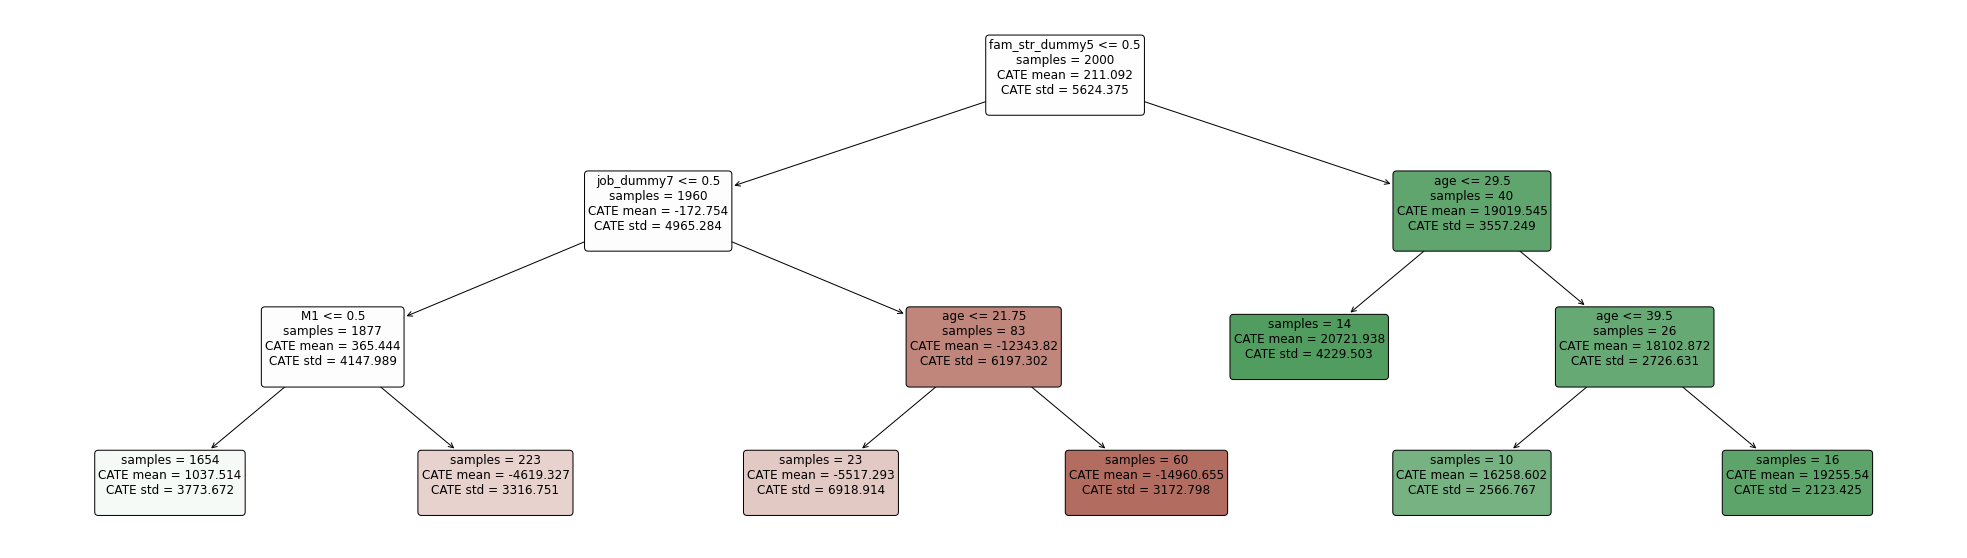

In [113]:
plot_model_interpreter(DLLeaner_model, test_data[COVARIATE_COLUMNS])

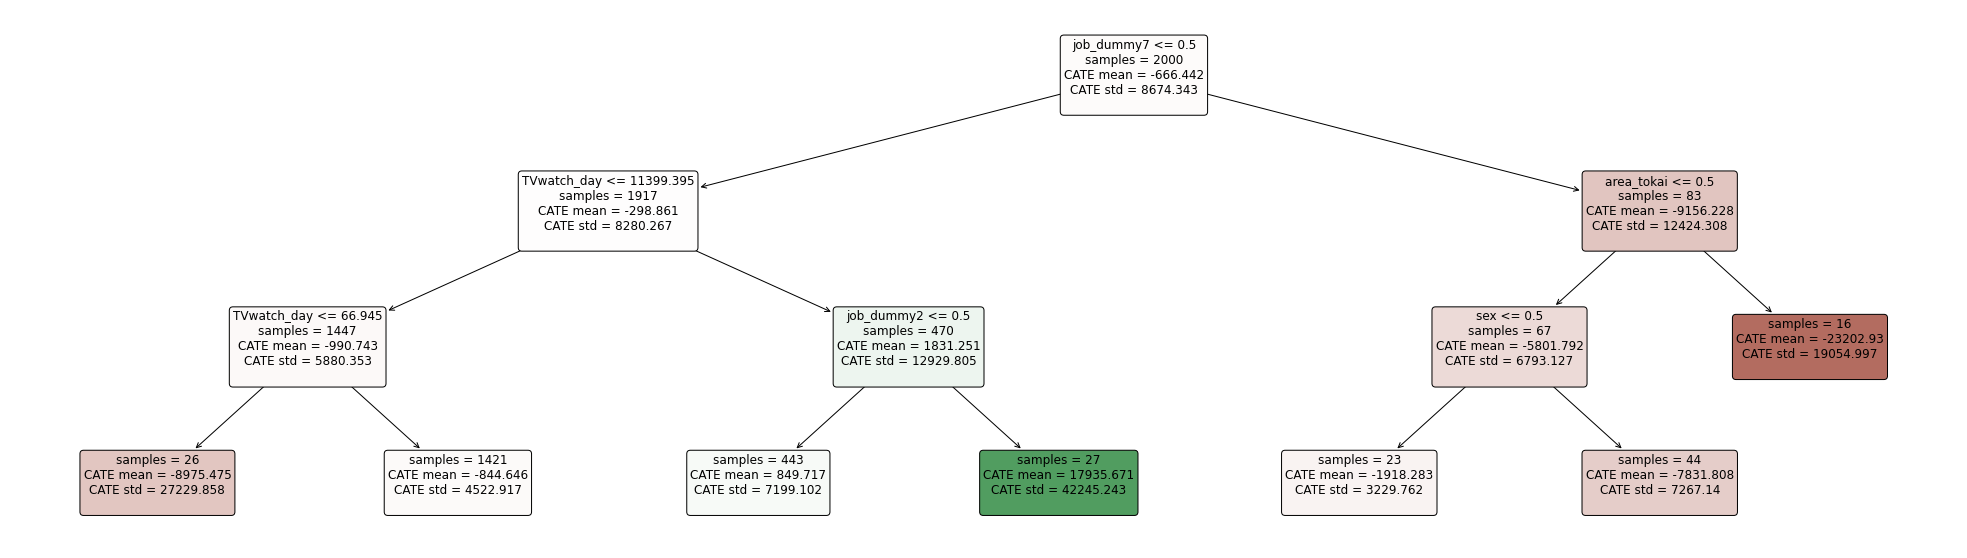

In [114]:
plot_model_interpreter(DALearner_model, test_data[COVARIATE_COLUMNS])

## 広告配信の戦略を決める
econmlに収録されているPolicyInterpreterを使う

In [0]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [0]:
def plot_model_policyinterpreter(model, X_df):
    # We find a tree-based treatment policy based on the CATE model
    intrp = SingleTreePolicyInterpreter(risk_level=0.05, 
                                        max_depth=3, min_samples_leaf=1,
                                        min_impurity_decrease=.001,
                                        random_state=7)
    intrp.interpret(model, X_df.values, sample_treatment_costs=0.2)
    # Plot the tree
    plt.figure(figsize=(35, 10))
    intrp.plot(feature_names=X_df.columns, fontsize=12)
    plt.show()

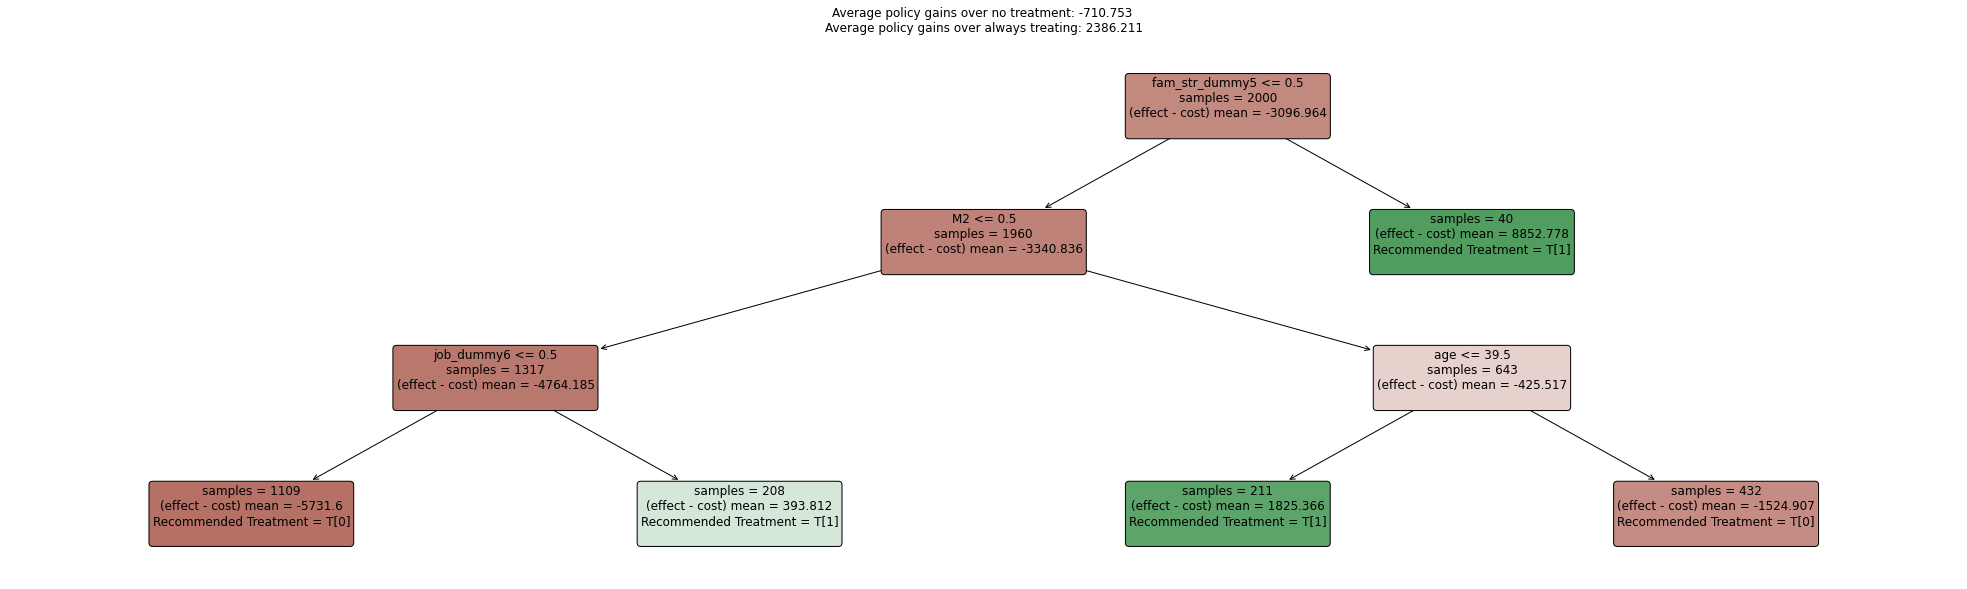

In [121]:
plot_model_policyinterpreter(DLLeaner_model, test_data[COVARIATE_COLUMNS])